In [12]:
import torch
import pyro
import matplotlib.pyplot as plt

from pyciemss.ODE.ode_models import SVIIvR
from pyciemss.ODE.observation_models import GaussianNoise
from pyciemss.ODE.abstractions import ODESolution

from pyciemss.utils import run_inference

from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.poutine import trace
from pyro.infer import Predictive

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Bayesian ODE Model in Pyro

In [14]:
N = 1000.
ode_model = SVIIvR(N)
observation_model = GaussianNoise(1., ["S", "V", "I", "Iv", "R"])
solution_model = ODESolution(ode_model, observation_model)

## Sample from the Prior

In [15]:
tspan = torch.linspace(0., 160., 160)
initial_state = torch.tensor([N-1., 0, 1., 0, 0])
# initial_state = [torch.as_tensor(s) for s in [N-1, 0., 1., 0., 0.]]
# print(initial_state)
S, V, I, Iv, R = solution_model(initial_state, tspan)

In [16]:
def plot_predictive(prediction, data, tspan, title=""):

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S", "V", "I", "Iv", "R"]
    S, V, I, Iv, R = [data[v].detach().numpy()/1000 for v in vars]

    S_low, V_low, I_low, Iv_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, Iv_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(tspan, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(tspan, S_low, S_up, color='b', alpha=0.2)
    ax.plot(tspan, V, 'purple', alpha=0.5, lw=2, label='SucceptibleVaccinated')
    ax.fill_between(tspan, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(tspan, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(tspan, I_low, I_up, color='r', alpha=0.2)
    ax.plot(tspan, Iv, 'green', alpha=0.5, lw=2, label='InfectedVaccinated')
    ax.fill_between(tspan, Iv_low, Iv_up, color='green', alpha=0.2)
    ax.plot(tspan, R, 'orange', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(tspan, R_low, R_up, color='orange', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

## Fix Parameters and Generate Data

In [17]:
true_parameters = {"ode_model.beta": 0.18, "ode_model.betaV": 0.13, "ode_model.gamma": 0.09, "ode_model.gammaV": 0.13, "ode_model.nu": 0.04}
true_model = pyro.condition(solution_model, true_parameters)

S_obs, V_obs, I_obs, Iv_obs, R_obs = true_model(initial_state, tspan)
data = {"S": S_obs, "V": V_obs, "I": I_obs, "Iv": Iv_obs, "R": R_obs}


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_49488/2748921612.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


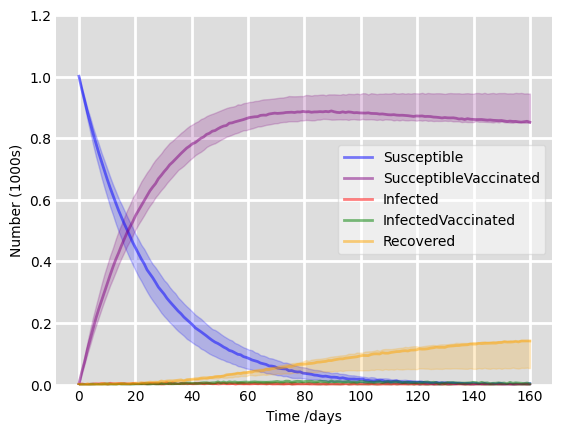

In [18]:
prior_prediction = Predictive(solution_model, num_samples=2)(initial_state, tspan)
plot_predictive(prior_prediction, data, tspan)

## Run Inference

In [19]:
guide = AutoDelta(solution_model)

run_inference(solution_model, guide, initial_state, tspan, data, num_iterations=25, verbose=True)

[iteration 0001] loss: 1727374.0649
[iteration 0051] loss: 1727374.0649
[iteration 0101] loss: 1727374.0649
[iteration 0151] loss: 1727374.0649
[iteration 0201] loss: 1727374.0649


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_49488/2748921612.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


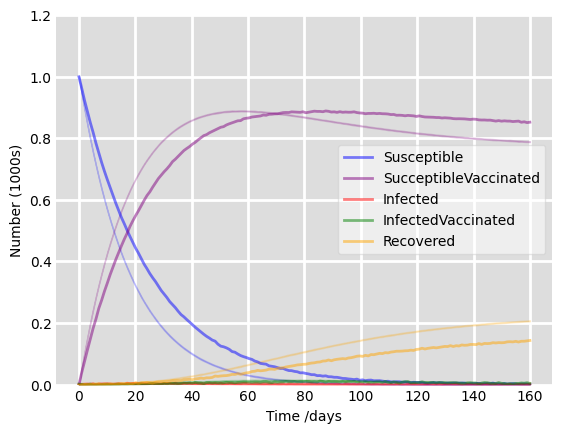

In [11]:
posterior_prediction = Predictive(solution_model, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(posterior_prediction, data, tspan)